In [387]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import yeojohnson
from scipy.stats.mstats import winsorize

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Embedding, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

from sklearn.cluster import MiniBatchKMeans

import joblib
from sklearn.metrics import classification_report, confusion_matrix

In [389]:
df_original = pd.read_csv('/content/drive/My Drive/IOT_FinalProject/weatherAUS.csv')

In [390]:
df = df_original.copy(deep=True)

In [391]:
# Global parameters
timesteps = 14 # look back window of 7 days
ph = 1  # Predictive horizon: 1 day ahead

# Model parameters
EPOCH = 100
BATCH_SIZE = 64
LEARNING_RATE = 1e-4

# Exploring dataset

In [392]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [393]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [394]:
print(f'The number of rows are {df.shape[0] } and the number of columns are {df.shape[1]}')

The number of rows are 145460 and the number of columns are 23


In [395]:
df.describe(include='object').T

,count,unique,top,freq
Date,145460,3436,2013-11-12,49
Location,145460,49,Canberra,3436
WindGustDir,135134,16,W,9915
WindDir9am,134894,16,N,11758
WindDir3pm,141232,16,SE,10838
RainToday,142199,2,No,110319
RainTomorrow,142193,2,No,110316


In [396]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MinTemp,143975.0,12.194034,6.398495,-8.5,7.6,12.0,16.9,33.9
MaxTemp,144199.0,23.221348,7.119049,-4.8,17.9,22.6,28.2,48.1
Rainfall,142199.0,2.360918,8.478060,0.0,0.0,0.0,0.8,371.0
Evaporation,82670.0,5.468232,4.193704,0.0,2.6,4.8,7.4,145.0
Sunshine,75625.0,7.611178,3.785483,0.0,4.8,8.4,10.6,14.5
WindGustSpeed,135197.0,40.035230,13.607062,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,143693.0,14.043426,8.915375,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,142398.0,18.662657,8.809800,0.0,13.0,19.0,24.0,87.0
Humidity9am,142806.0,68.880831,19.029164,0.0,57.0,70.0,83.0,100.0
Humidity3pm,140953.0,51.539116,20.795902,0.0,37.0,52.0,66.0,100.0


In [397]:
# checking null values
(df.isna().mean()*100).sort_values(ascending=False)

,0
Sunshine,48.009762
Evaporation,43.166506
Cloud3pm,40.807095
Cloud9am,38.421559
Pressure9am,10.356799
Pressure3pm,10.331363
WindDir9am,7.263853
WindGustDir,7.098859
WindGustSpeed,7.055548
Humidity3pm,3.098446


# Data Pre-Processing

In [398]:
df= df.sort_values(['Location', 'Date'])

In [399]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
96320,2008-07-01,Adelaide,8.8,15.7,5.0,1.6,2.6,NW,48.0,SW,...,92.0,67.0,1017.4,1017.7,NaN,NaN,13.5,14.9,Yes,No
96321,2008-07-02,Adelaide,12.7,15.8,0.8,1.4,7.8,SW,35.0,SSW,...,75.0,52.0,1022.4,1022.6,NaN,NaN,13.7,15.5,No,No
96322,2008-07-03,Adelaide,6.2,15.1,0.0,1.8,2.1,W,20.0,NNE,...,81.0,56.0,1027.8,1026.5,NaN,NaN,9.3,13.9,No,No
96323,2008-07-04,Adelaide,5.3,15.9,0.0,1.4,8.0,NNE,30.0,NNE,...,71.0,46.0,1028.7,1025.6,NaN,NaN,10.2,15.3,No,No
96324,2008-07-05,Adelaide,9.8,15.4,0.0,NaN,0.9,N,30.0,NNE,...,56.0,67.0,1023.6,1020.2,NaN,NaN,11.3,13.8,No,NaN


## Categorical variables processing

In [400]:
categorical_cols = df.select_dtypes(include='object').columns

print(f'Categorical columns are {categorical_cols.values}')

Categorical columns are ['Date' 'Location' 'WindGustDir' 'WindDir9am' 'WindDir3pm' 'RainToday'
 'RainTomorrow']


The weather usually depends on lot of factors including **seasonality**. We need to properly handly date field to capture this.

1. One way is to convert to unix format (ignores seasonality but faster processing)
2. Cyclical Encoding. In this we take sin(day), sin(month) and cos(day), cos(month).

What this essentially means is that, if we have 2 dates day 1 of next month and day 31 current month. The models learns that there are 30 day difference if cyclic incode is not given. If cyclic encoding is used, it essentiall gives a similar value for both of them (means closer).

Below is an representation of day and month being cyclic in nature (for our dataset)

Text(0, 0.5, 'days in a month')

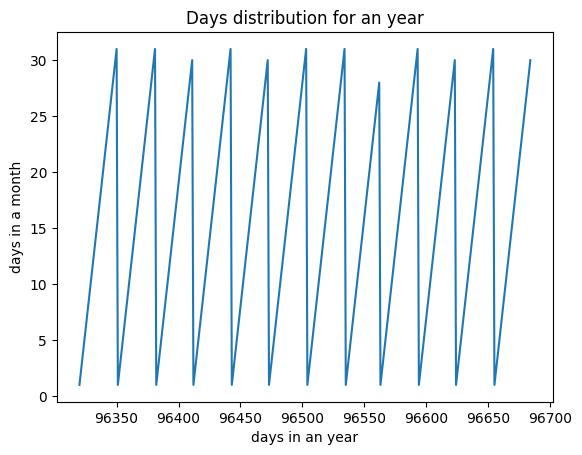

In [401]:
df['Date'] = pd.to_datetime(df['Date'])

ax = df['Date'].dt.day[:365].plot()
ax.set_title("Days distribution for an year")
ax.set_xlabel("days in an year")
ax.set_ylabel("days in a month")

In [402]:
df['Year'] = df['Date'].dt.year

df['sin_month'] = np.sin(2*np.pi*df['Date'].dt.month/12)
df['cos_month'] = np.cos(2*np.pi*df['Date'].dt.month/12)

df['sin_day'] = np.sin(2*np.pi*df['Date'].dt.day/31)
df['cos_day'] = np.cos(2*np.pi*df['Date'].dt.day/31)

# We should drop date colum as it is unnecessary (dropped later)

In [403]:
df[categorical_cols].describe()

,Date
count,145460
mean,2013-04-04 21:08:51.907053568
min,2007-11-01 00:00:00
25%,2011-01-11 00:00:00
50%,2013-06-02 00:00:00
75%,2015-06-14 00:00:00
max,2017-06-25 00:00:00


In [404]:
(df[categorical_cols].isna().mean()*100).sort_values(ascending=False)

,0
WindDir9am,7.263853
WindGustDir,7.098859
WindDir3pm,2.906641
RainTomorrow,2.245978
RainToday,2.241853
Date,0.000000
Location,0.000000


We have a maz of 7.26% null values in categories. We can use mode to fill them.

In [405]:
for col in df[categorical_cols].columns:
  df[col] = df[col].ffill()

# Checking nulls after imputation
(df[categorical_cols].isna().mean()*100).sort_values(ascending=False)

,0
Date,0.0
Location,0.0
WindGustDir,0.0
WindDir9am,0.0
WindDir3pm,0.0
RainToday,0.0
RainTomorrow,0.0


From above table, we can understand that Date is not unique throughout column but to each location. Weather is location specific. It essentially means we have 49 time series problems. There are 2 ways 2 solve this,
1. using 49 LSTM models
2. use one LSTM model but encode location (one-hot encoding - 49 new features)

The second method is more efficient if we efficiently handly the one-hot encoding part. So instead of doing onehot encoding, we can do embedding (converting 49 columns to 10 columns(say)).

For Location feature - 2 steps are followed:
1. label encoding (49 unique values)
2. Embedding layer while building lstm model

For other categories, we can use label encoder.

In [406]:
for col in df[categorical_cols].columns:
  if col != 'Date':
    df[col] = LabelEncoder().fit_transform(df[col])

In [407]:
# All columns are now converted numerically (except Location column - handled later)
df[categorical_cols].describe()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,145460,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000
mean,2013-04-04 21:08:51.907053568,23.793524,7.998824,7.337165,7.813694,0.225230,0.225210
min,2007-11-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2011-01-11 00:00:00,11.000000,4.000000,3.000000,4.000000,0.000000,0.000000
50%,2013-06-02 00:00:00,24.000000,8.000000,7.000000,8.000000,0.000000,0.000000
75%,2015-06-14 00:00:00,36.000000,12.000000,11.000000,12.000000,0.000000,0.000000
max,2017-06-25 00:00:00,48.000000,15.000000,15.000000,15.000000,1.000000,1.000000
std,NaN,14.228687,4.719862,4.522382,4.588877,0.417735,0.417722


# Numeric variable processing

In [408]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,145460,2013-04-04 21:08:51.907053568,2007-11-01 00:00:00,2011-01-11 00:00:00,2013-06-02 00:00:00,2015-06-14 00:00:00,2017-06-25 00:00:00,NaN
Location,145460.0,23.793524,0.0,11.0,24.0,36.0,48.0,14.228687
MinTemp,143975.0,12.194034,-8.5,7.6,12.0,16.9,33.9,6.398495
MaxTemp,144199.0,23.221348,-4.8,17.9,22.6,28.2,48.1,7.119049
Rainfall,142199.0,2.360918,0.0,0.0,0.0,0.8,371.0,8.47806
Evaporation,82670.0,5.468232,0.0,2.6,4.8,7.4,145.0,4.193704
Sunshine,75625.0,7.611178,0.0,4.8,8.4,10.6,14.5,3.785483
WindGustDir,145460.0,7.998824,0.0,4.0,8.0,12.0,15.0,4.719862
WindGustSpeed,135197.0,40.03523,6.0,31.0,39.0,48.0,135.0,13.607062
WindDir9am,145460.0,7.337165,0.0,3.0,7.0,11.0,15.0,4.522382


In [409]:
numerical_cols = df.select_dtypes(include=np.number).columns

print(f'Numerical columns are {numerical_cols.values}\n\n')

Numerical columns are ['Location' 'MinTemp' 'MaxTemp' 'Rainfall' 'Evaporation' 'Sunshine'
 'WindGustDir' 'WindGustSpeed' 'WindDir9am' 'WindDir3pm' 'WindSpeed9am'
 'WindSpeed3pm' 'Humidity9am' 'Humidity3pm' 'Pressure9am' 'Pressure3pm'
 'Cloud9am' 'Cloud3pm' 'Temp9am' 'Temp3pm' 'RainToday' 'RainTomorrow'
 'Year' 'sin_month' 'cos_month' 'sin_day' 'cos_day']




In [410]:
(df[numerical_cols].isna().mean()*100).sort_values(ascending=False)

,0
Sunshine,48.009762
Evaporation,43.166506
Cloud3pm,40.807095
Cloud9am,38.421559
Pressure9am,10.356799
Pressure3pm,10.331363
WindGustSpeed,7.055548
Humidity3pm,3.098446
Temp3pm,2.481094
Rainfall,2.241853


Since more than 38% of data is missing for some columns. We can use mean for 4 columns. For other columns, we can use ffill (to retain patterns for each location - data is sorted by location and date)

In [411]:
cols_mean_imputation = ['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']
for col in df[numerical_cols].columns:
  if col not in cols_mean_imputation:
    df[col] = df[col].ffill()

# Checking nulls after ffill imputation
(df[numerical_cols].isna().mean()*100).sort_values(ascending=False)

,0
Sunshine,48.009762
Evaporation,43.166506
Cloud3pm,40.807095
Cloud9am,38.421559
Location,0.000000
Pressure3pm,0.000000
sin_day,0.000000
cos_month,0.000000
sin_month,0.000000
Year,0.000000


In [412]:
# Mean imputation for nulls greater than 38%
df[cols_mean_imputation] = df[cols_mean_imputation].fillna(df[cols_mean_imputation].mean())

In [413]:
# Checking nulls after mean imputation
(df[cols_mean_imputation].isna().mean()*100).sort_values(ascending=False)

,0
Sunshine,0.0
Evaporation,0.0
Cloud3pm,0.0
Cloud9am,0.0


# Standardizating features

In [414]:
df.columns.values

array(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed',
       'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
       'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday',
       'RainTomorrow', 'Year', 'sin_month', 'cos_month', 'sin_day',
       'cos_day'], dtype=object)

In [415]:
# Lets split features and target variable

features = df.drop(['Date', 'RainTomorrow'], axis=1)
target = df['RainTomorrow']

In [416]:
# understand skewness of features
skewness = features[features.select_dtypes(np.number).columns].skew()
print("\nSkewness of Features:\n", skewness[np.abs(skewness)>1])


Skewness of Features:
 Rainfall       9.717048
Evaporation    4.989198
RainToday      1.315539
dtype: float64


We can ignore columns like Rain Today and Rain Tomorrow(already removed in features) as they are binary values. We can treat columns whose skew is less than or greater than 1.

In [417]:
# Check if these two cols have 0 or negative values.
print((features['Evaporation'] <= 0).sum())
print(((features['Rainfall'] <= 0).sum()))

244
93130


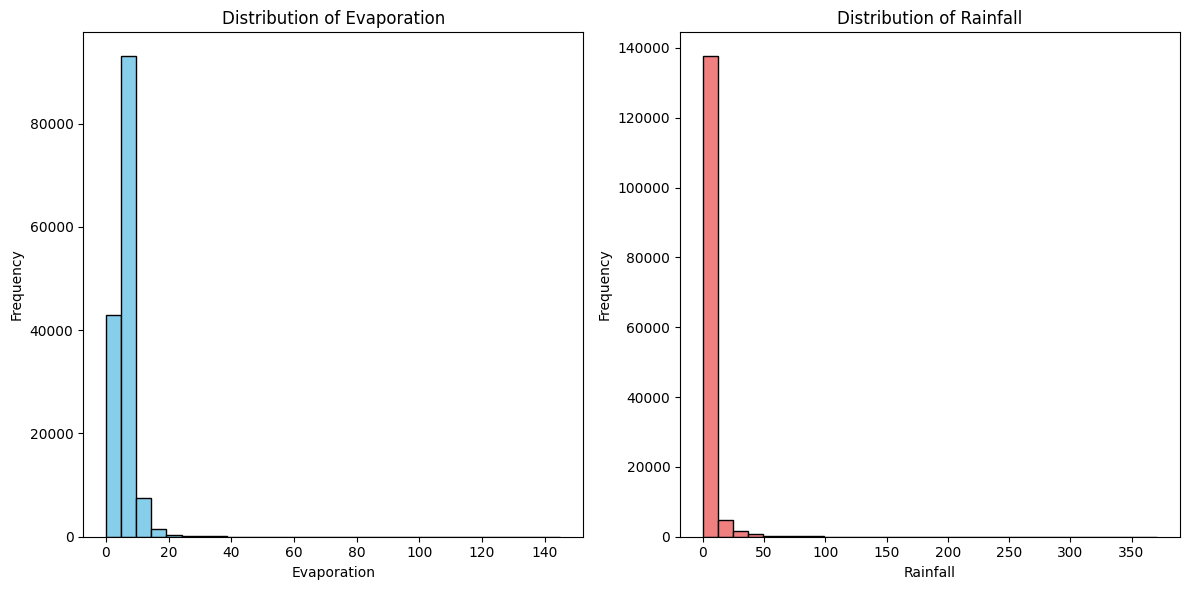

In [418]:
plt.figure(figsize=(12, 6))

# Plot Evaporation distribution
plt.subplot(1, 2, 1)
plt.hist(features['Evaporation'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Evaporation')
plt.xlabel('Evaporation')
plt.ylabel('Frequency')

# Plot Rainfall distribution
plt.subplot(1, 2, 2)
plt.hist(features['Rainfall'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of Rainfall')
plt.xlabel('Rainfall')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


We have zero values, We can use yeojohnson transformation for Evaporation to reduce skewness.

For rainfall column, If rainfall is zero, it essentially means, there is no rainfall, we can just apply log transformation for the Zero or positive values.

In [419]:
# Checking if RainToday is 'No' when Rainfall is Zero
assert (features['RainToday'].loc[features['Rainfall'] == 0.0] == 0).all()

In [420]:
features['Evaporation'], lambda_ = yeojohnson(features['Evaporation'] + 1e-6)  # Small offset to avoid zero issues
features['Rainfall'] = np.log1p(features['Rainfall'])

In [421]:
print(f'Skew of Evaporation is {round(features["Evaporation"].skew(),2)} and Skew of Rainfall is {round(features["Rainfall"].skew(),2)}')

Skew of Evaporation is 0.12 and Skew of Rainfall is 2.03


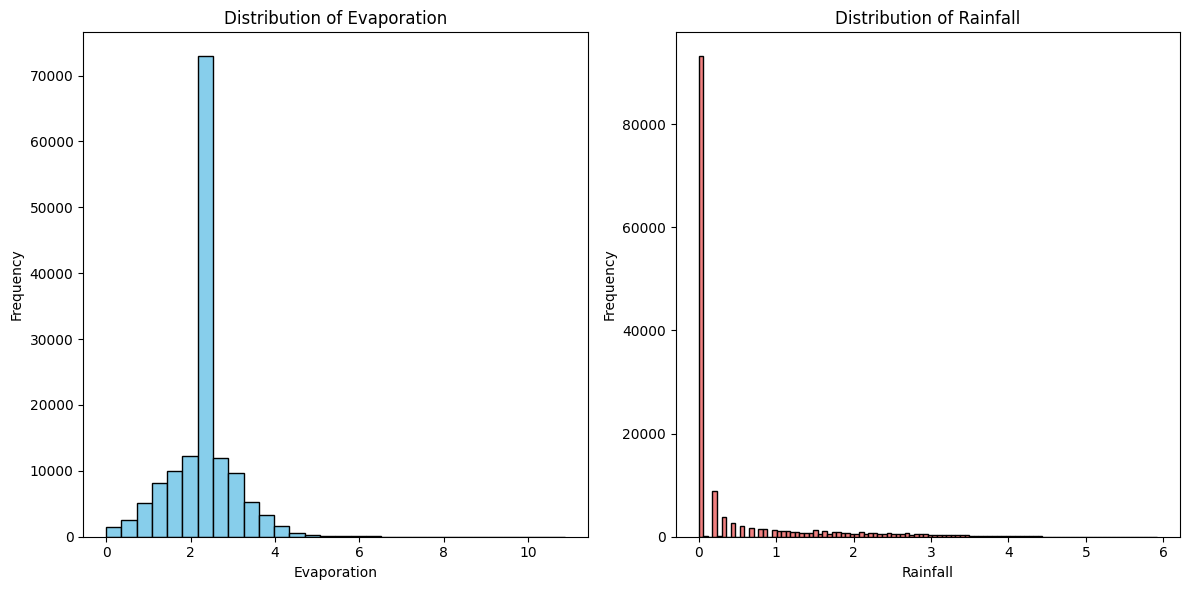

In [422]:
plt.figure(figsize=(12, 6))

# Plot Evaporation distribution
plt.subplot(1, 2, 1)
plt.hist(features['Evaporation'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Evaporation')
plt.xlabel('Evaporation')
plt.ylabel('Frequency')

# Plot Rainfall distribution
plt.subplot(1, 2, 2)
plt.hist(features['Rainfall'], bins=100, color='lightcoral', edgecolor='black')
plt.title('Distribution of Rainfall')
plt.xlabel('Rainfall')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Standardizing the numeric values with mean of 0 and variance of 1

In [423]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(features.loc[:,~features.columns.isin(['RainToday', 'Location'])])  # RainToday is boolean - no need to scale them. Location column will be added to embedding layer later.

X_scaled.shape

(145460, 24)

In [424]:
# Convert X_scaled to DataFrame
df_scaled = pd.DataFrame(X_scaled, columns=features.loc[:,~features.columns.isin(['RainToday', 'Location'])].columns, index=features.index)

df_scaled = pd.concat([df_scaled, features['RainToday'], features['Location']], axis=1)

print("\nShape of Scaled DataFrame:", df_scaled.shape)


Shape of Scaled DataFrame: (145460, 26)


In [425]:
df_scaled.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Cloud3pm,Temp9am,Temp3pm,Year,sin_month,cos_month,sin_day,cos_day,RainToday,Location
96320,-0.533629,-1.058111,1.431063,-1.689279,-1.835948,-0.211622,0.550905,1.031061,1.130195,-0.117146,...,0.0,-0.534527,-0.976641,-1.879575,-0.725379,-1.198979,0.278970,1.426023,1,0
96321,0.076238,-1.044044,0.107571,-1.830076,0.069179,0.847734,-0.345947,0.809938,0.912276,-0.117146,...,0.0,-0.503759,-0.890318,-1.879575,-0.725379,-1.198979,0.549587,1.339551,0,0
96322,-0.940207,-1.142509,-0.538566,-1.556072,-2.019134,1.059606,-1.380776,-0.516801,0.912276,-1.349811,...,0.0,-1.180652,-1.120512,-1.879575,-0.725379,-1.198979,0.797572,1.199371,0,0
96323,-1.080945,-1.029978,-0.538566,-1.830076,0.142453,-0.635365,-0.690890,-0.516801,-0.831076,-0.901569,...,0.0,-1.042197,-0.919092,-1.879575,-0.725379,-1.198979,1.012774,1.011221,0,0
96324,-0.377253,-1.100310,-0.538566,0.158024,-2.458778,-1.059107,-0.690890,-0.516801,-0.831076,-0.565388,...,0.0,-0.872974,-1.134900,-1.879575,-0.725379,-1.198979,1.186382,0.782805,0,0


# Handling Outliers

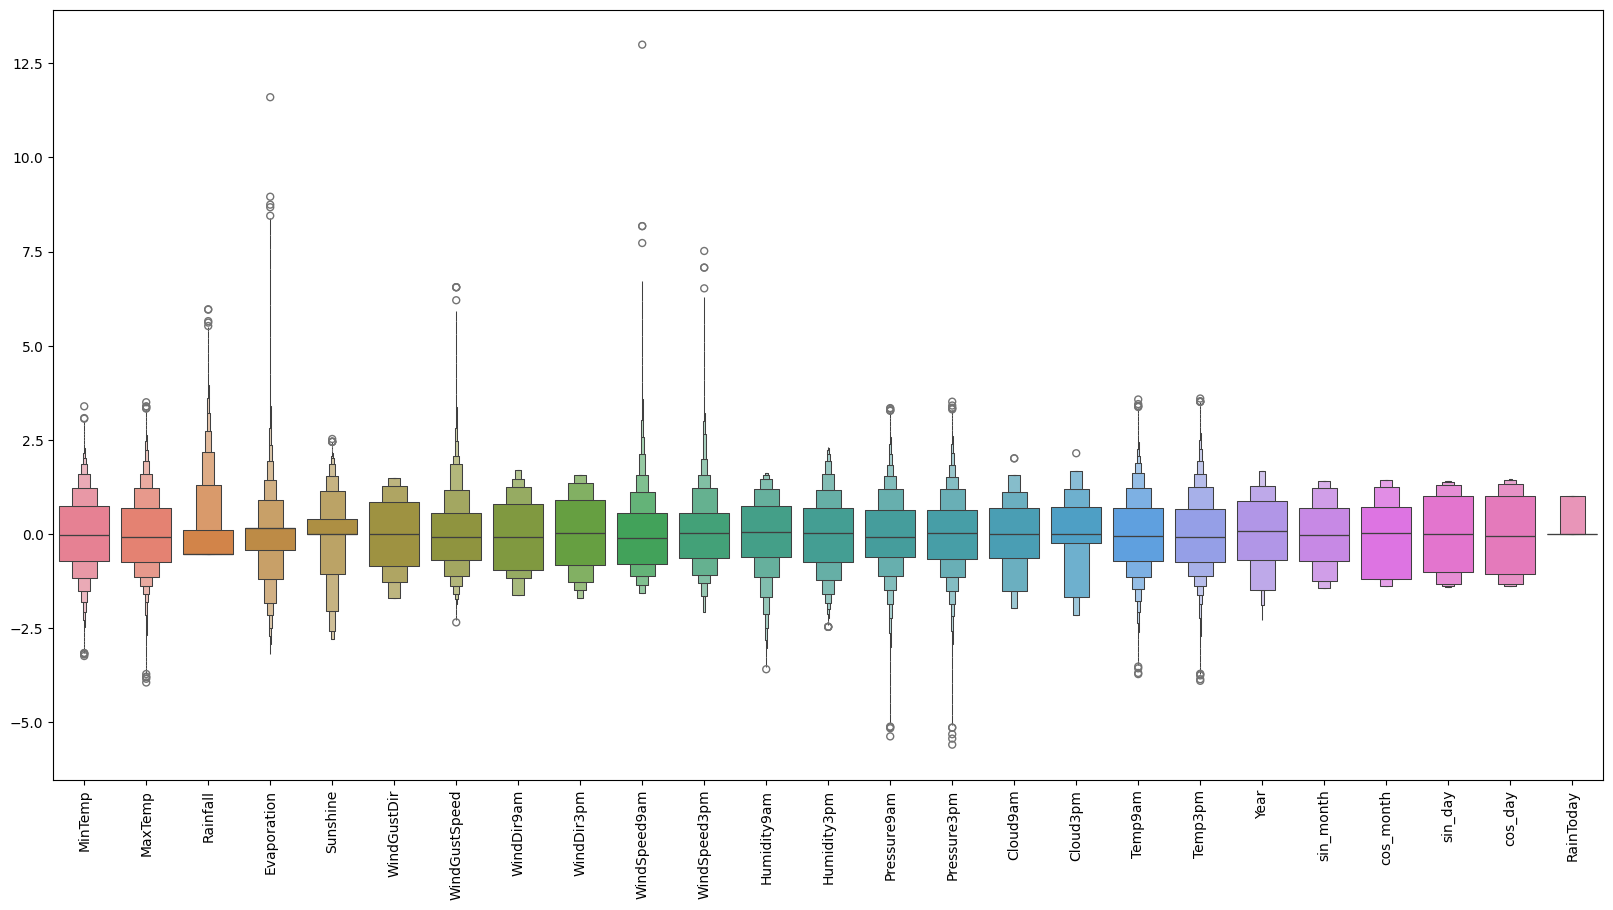

In [426]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = df_scaled.loc[:, df_scaled.columns != 'Location'])
plt.xticks(rotation=90)
plt.show()

We have lot of outliers in few of the features. We can clip them to 1% and 99% Quartile values rather than removing them since we are working with LSTM (temporal sequence is important)

In [427]:
columns_to_clip_top = ['Rainfall', 'Evaporation', 'WindGustSpeed','WindSpeed9am', 'WindSpeed3pm', 'Pressure9am', 'Pressure3pm']

for col in columns_to_clip_top:
  df_scaled[col] = winsorize(df_scaled[col], limits=[0.01, 0.01]) # 1% and 99% quartile



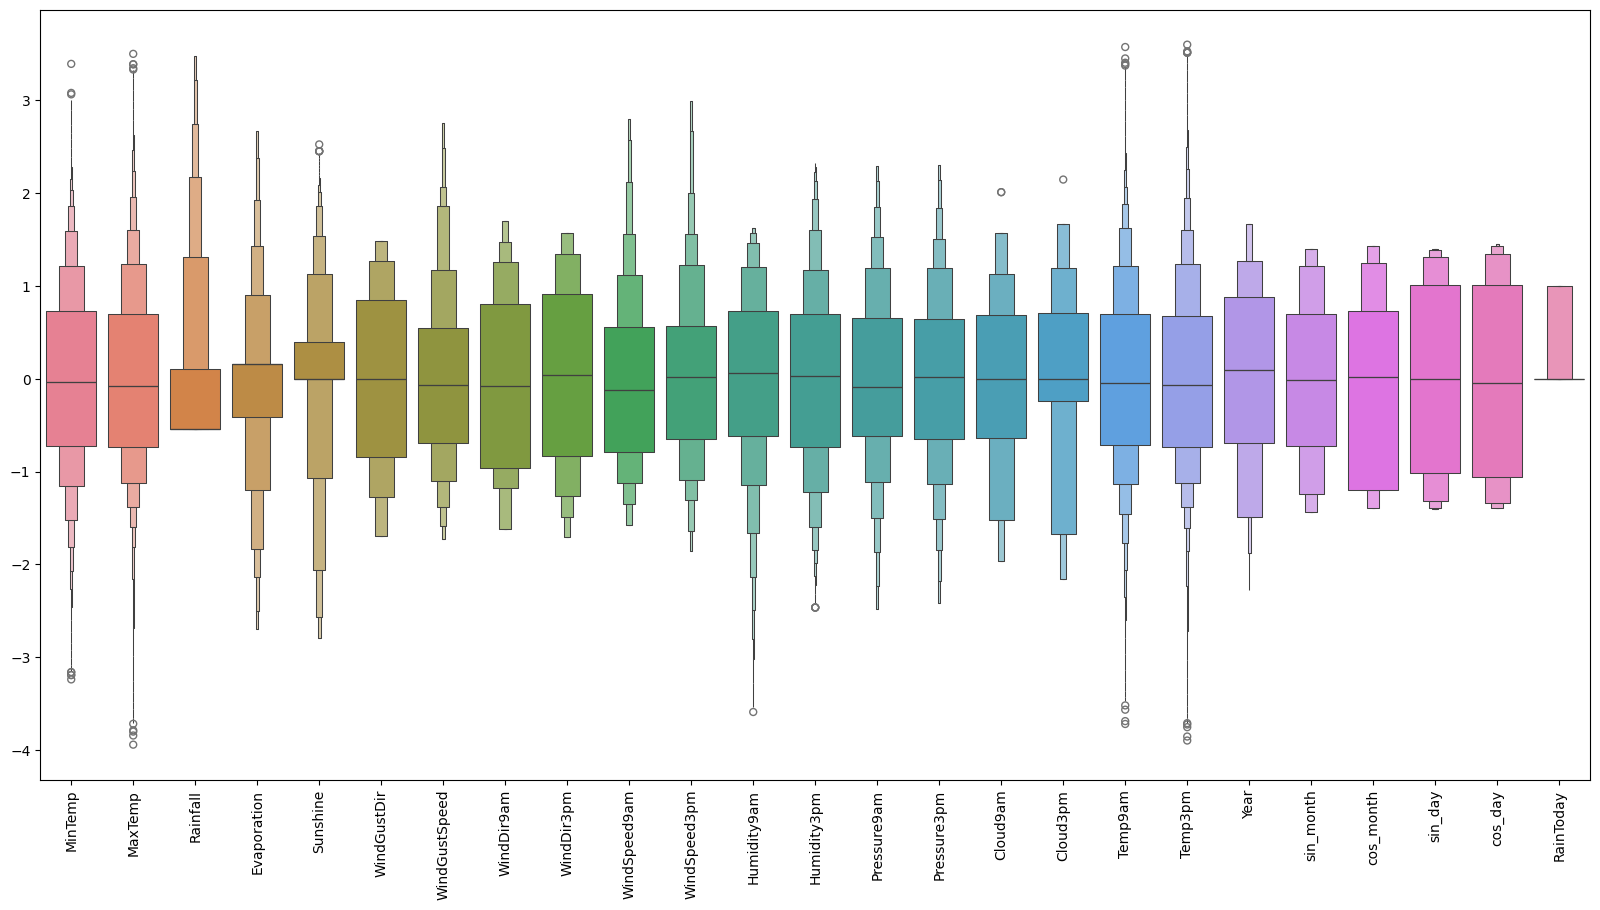

In [428]:
plt.figure(figsize=(20,10))
sns.boxenplot(data =  df_scaled.loc[:, df_scaled.columns != 'Location'])
plt.xticks(rotation=90)
plt.show()

# Correlation

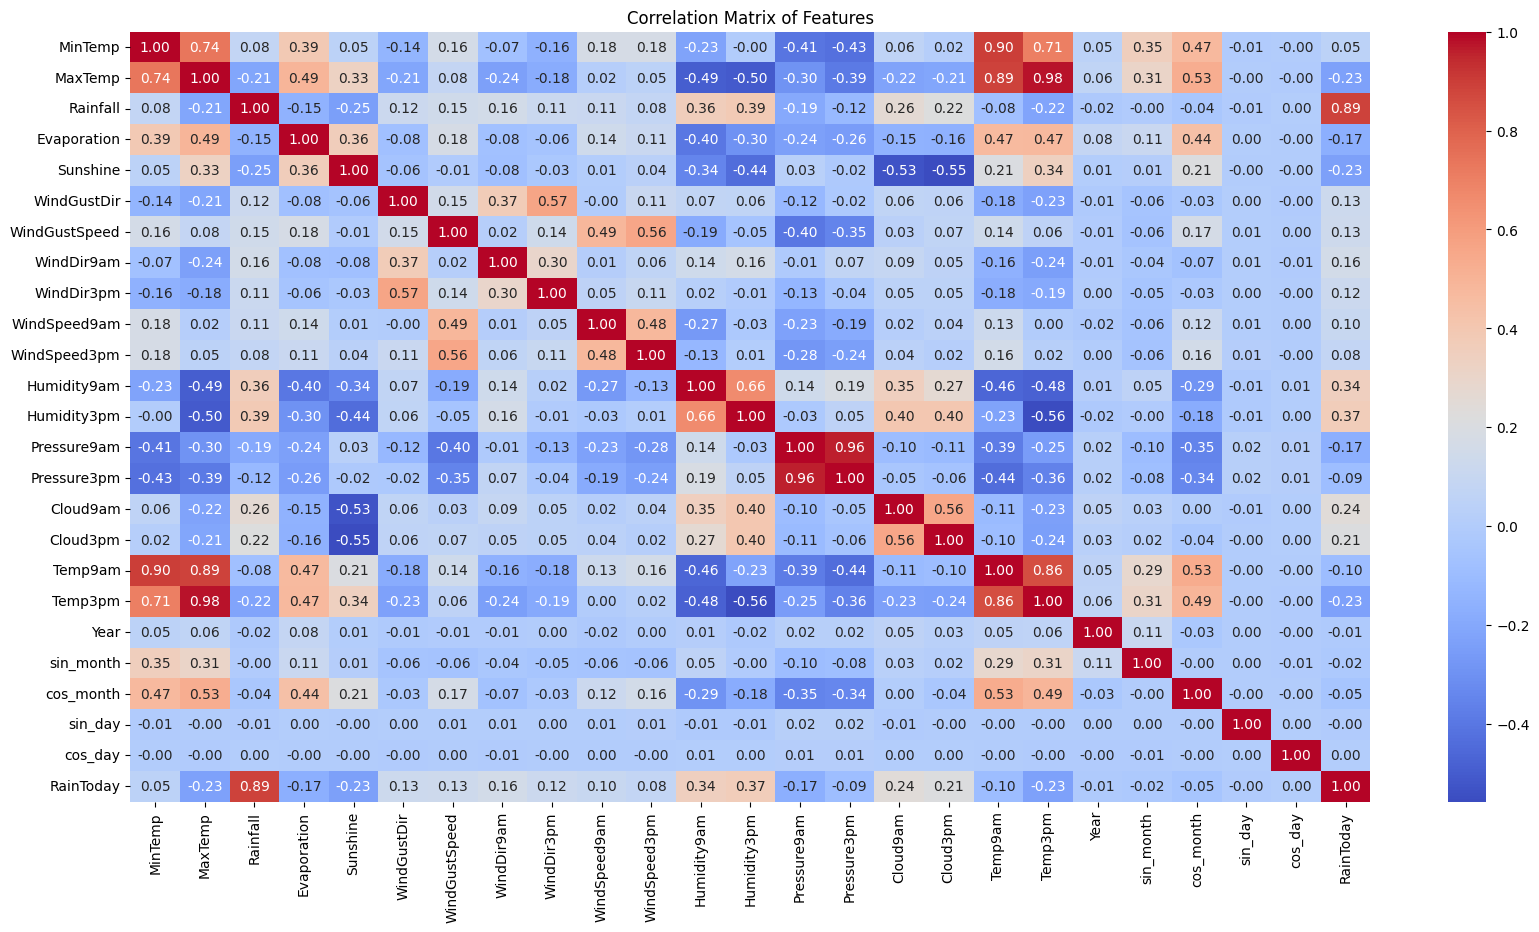

In [429]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_scaled.loc[:, df_scaled.columns != 'Location'].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

The temperature features are highly correlated

In [430]:
from sklearn.decomposition import PCA
import numpy as np

# Selecting only the temperature features
temp_features = features[["MaxTemp", "MinTemp", "Temp9am","Temp3pm"]]

# Apply PCA
pca = PCA(n_components=4)  # We have 4 temperature features
pca.fit(temp_features)

# Explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)
print("Explained Variance Ratio:", explained_variance)

Explained Variance Ratio: [0.8882887  0.98167539 0.99508387 1.        ]


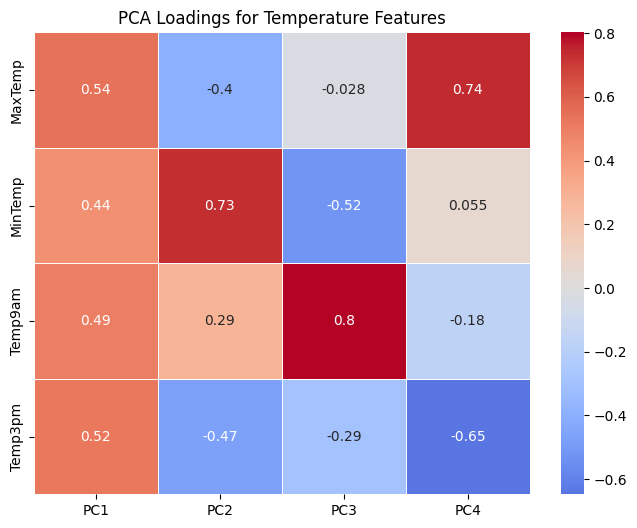

In [431]:
# Extract PCA loadings (component-wise feature importance)
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to get features as rows
    index=temp_features.columns,  # Feature names
    columns=[f"PC{i+1}" for i in range(4)]  # Principal components
)

# Plot heatmap of feature loadings
plt.figure(figsize=(8, 6))
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("PCA Loadings for Temperature Features")
plt.show()


The first two PCA is able to explain 98.1% of the information. So we can drop other two features.
Order of importance of PCi values (PC1 > PC2 > PC3 > PC4)

in PC1, Temp3pm and MaxTemp contribute almost same onfo (0.52 & 0.54 - highly correlated) while Temp9am and MinTemp are closely related (0.44 & 0.49).

So we can drop Temp3pm and Temp9am

In [432]:
# Saving a copy before dropping columns
df_scaled_copy = df_scaled.copy(deep=True)

In [433]:
df_scaled = df_scaled.drop(['Temp3pm', 'Temp9am'], axis=1)
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145460 entries, 96320 to 108570
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   MinTemp        145460 non-null  float64
 1   MaxTemp        145460 non-null  float64
 2   Rainfall       145460 non-null  float64
 3   Evaporation    145460 non-null  float64
 4   Sunshine       145460 non-null  float64
 5   WindGustDir    145460 non-null  float64
 6   WindGustSpeed  145460 non-null  float64
 7   WindDir9am     145460 non-null  float64
 8   WindDir3pm     145460 non-null  float64
 9   WindSpeed9am   145460 non-null  float64
 10  WindSpeed3pm   145460 non-null  float64
 11  Humidity9am    145460 non-null  float64
 12  Humidity3pm    145460 non-null  float64
 13  Pressure9am    145460 non-null  float64
 14  Pressure3pm    145460 non-null  float64
 15  Cloud9am       145460 non-null  float64
 16  Cloud3pm       145460 non-null  float64
 17  Year           145460 non-null

Create LSTM Sequence

# Unsupervised ML Model Building

Objective : Wind classification(calm, breezy, windy) based on the following columns -> (Wind speed, direction, temperature and ,pressure)

In [434]:
df_scaled_copy.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'Year', 'sin_month', 'cos_month', 'sin_day', 'cos_day',
       'RainToday', 'Location'],
      dtype='object')

In [435]:
features = ['WindDir9am', 'WindDir3pm','WindSpeed9am', 'WindSpeed3pm', 'Temp3pm', 'Temp9am', 'Pressure3pm', 'Pressure9am']

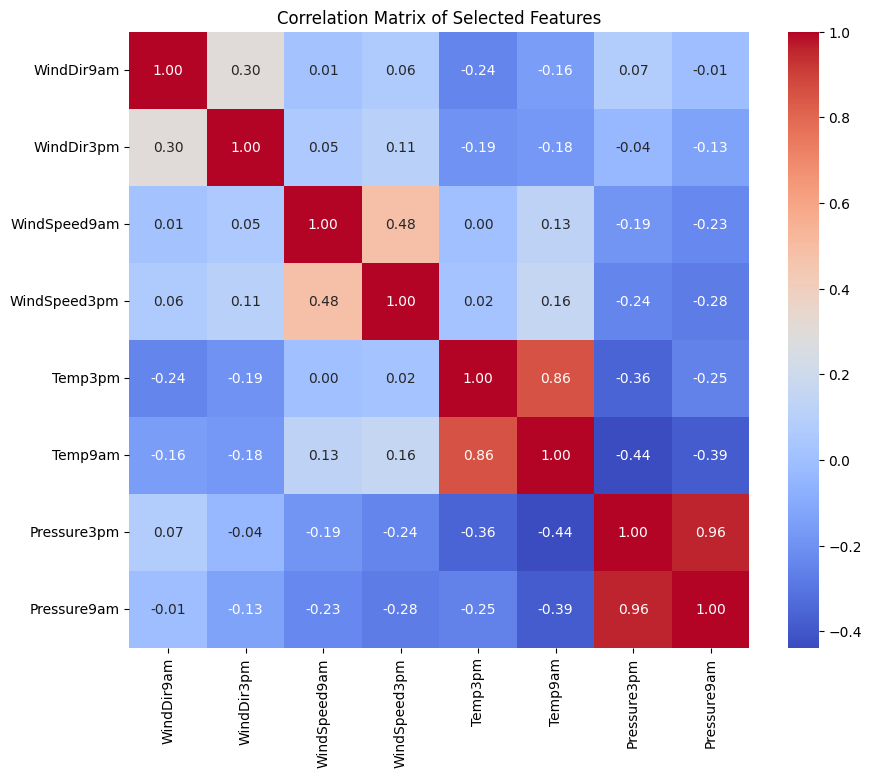

In [436]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_scaled_copy[features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Features')
plt.show()

In [437]:
kmeans = MiniBatchKMeans(n_clusters=3, batch_size=2000, random_state=42)
labels = kmeans.fit_predict(df_scaled_copy[features])
labels

array([2, 2, 2, ..., 1, 2, 2], dtype=int32)

In [438]:

joblib.dump(kmeans, '/content/kmeans_model.pkl')

['/content/kmeans_model.pkl']

In [439]:
df["Cluster"] = labels
df_cluster = df[[*features, 'Cluster']]

In [440]:
df_cluster['Cluster'].value_counts()

,count
Cluster,
2,57198
0,45700
1,42562


In [441]:
df_cluster.groupby('Cluster').mean()

,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Temp3pm,Temp9am,Pressure3pm,Pressure9am
Cluster,,,,,,,,
0,6.716061,7.923020,14.177287,19.890284,27.874414,22.997700,1009.055046,1011.692033
1,5.896880,6.250975,19.635121,23.933109,20.970290,16.915086,1015.739882,1018.042510
2,8.905154,8.889192,9.780569,14.230707,17.279971,12.206491,1020.426044,1022.477667


# Cluster Labeling  
Each cluster describes different weather conditions:

### **Cluster 0** (Low Pressure, Hot & Windy) → **"Windy & Hot"**  

  * **Pressure:** Lowest (1009-1012 hPa), indicating unstable conditions.  
  * **Temperature:** Hottest (28°C at 3pm, 23°C in the morning).  
  * **Wind:** Strongest winds (19-24 km/h).  
  * **Label:** **"Windy & Hot"** (Warmest, strongest wind, unstable conditions).  

### **Cluster 1** (Moderate Pressure, Mild & Breezy) → **"Breezy & Mild"**  

  * **Pressure:** Medium (1016-1018 hPa).  
  * **Temperature:** Cooler (21°C at 3pm, 17°C in the morning).  
  * **Wind:** Moderate winds (19-24 km/h).  
  * **Label:** **"Breezy & Mild"** (Cooler temperatures, breezy conditions).  

### **Cluster 2** (High Pressure, Cool & Light Wind) → **"Cool & Stable"**  

  * **Pressure:** Highest (1020-1023 hPa), indicating very stable weather.  
  * **Temperature:** Coolest (17°C at 3pm, 12°C in the morning).  
  * **Wind:** Lightest winds (9-14 km/h).  
  * **Label:** **"Cool & Stable"** (Calm, stable weather with minimal wind).  


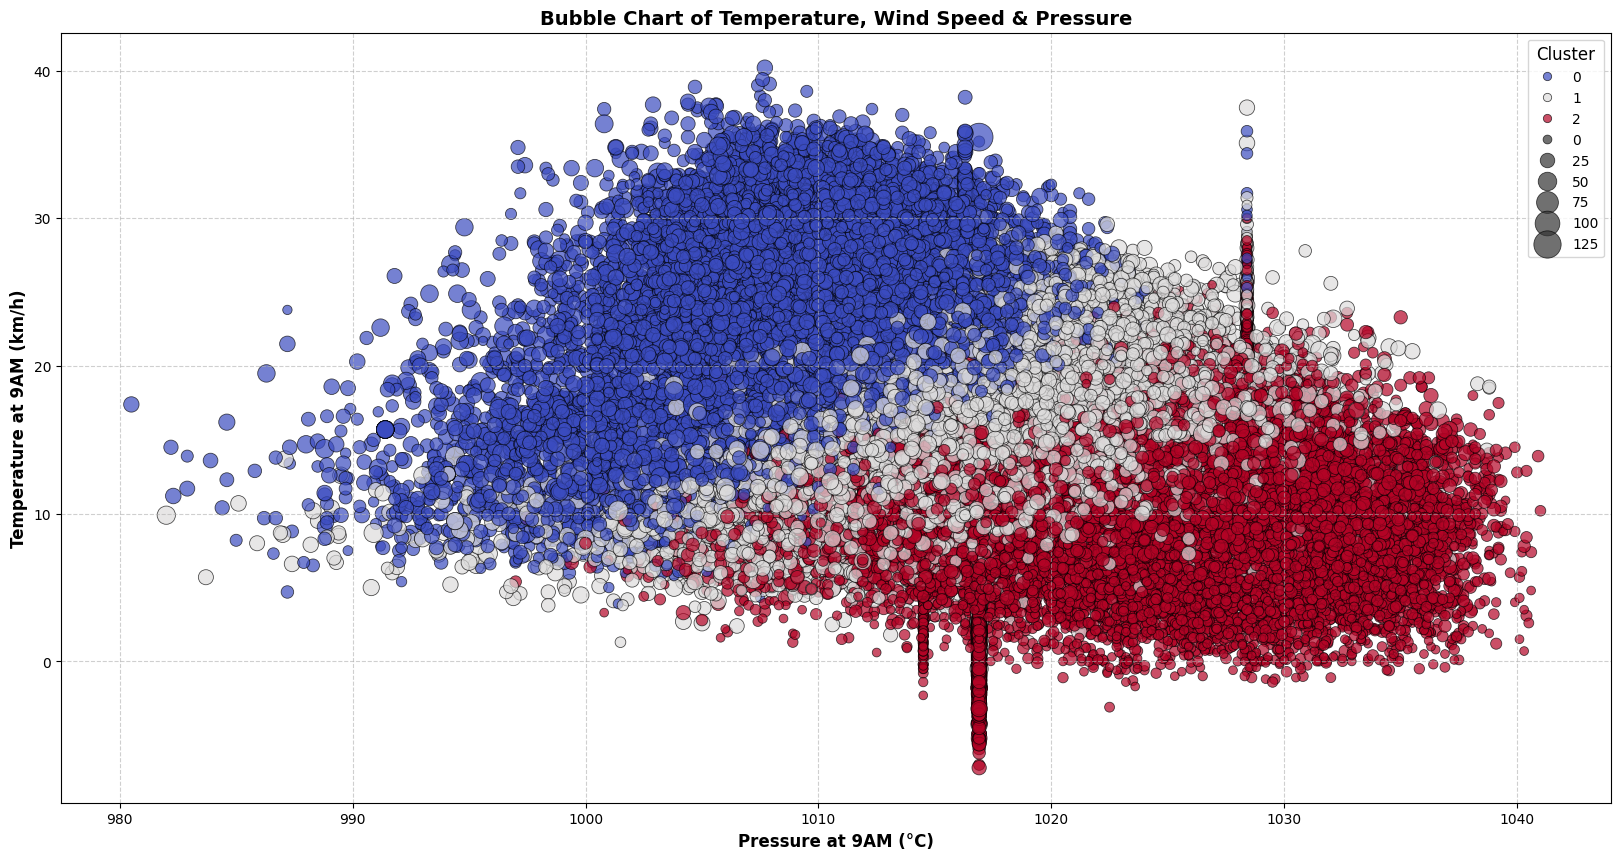

In [442]:
plt.figure(figsize=(20, 10))
sns.scatterplot(
    x=df_cluster['Pressure9am'],
    y=df_cluster['Temp9am'],
    hue=labels,
    size=df_cluster['WindSpeed9am'],  # Bubble size
    sizes=(40, 400),
    palette="coolwarm",
    alpha=0.7,
    edgecolor="black"
)

plt.xlabel("Pressure at 9AM (°C)", fontsize=12, fontweight='bold')
plt.ylabel("Temperature at 9AM (km/h)", fontsize=12, fontweight='bold')
plt.title("Bubble Chart of Temperature, Wind Speed & Pressure", fontsize=14, fontweight='bold')

plt.legend(title="Cluster", title_fontsize=12, fontsize=10, loc="best")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


From the above isualization, we can see that, cluster 0 (blue) has the mean highest temperature followed by cluster 2 (white) and cluster 3 (red)

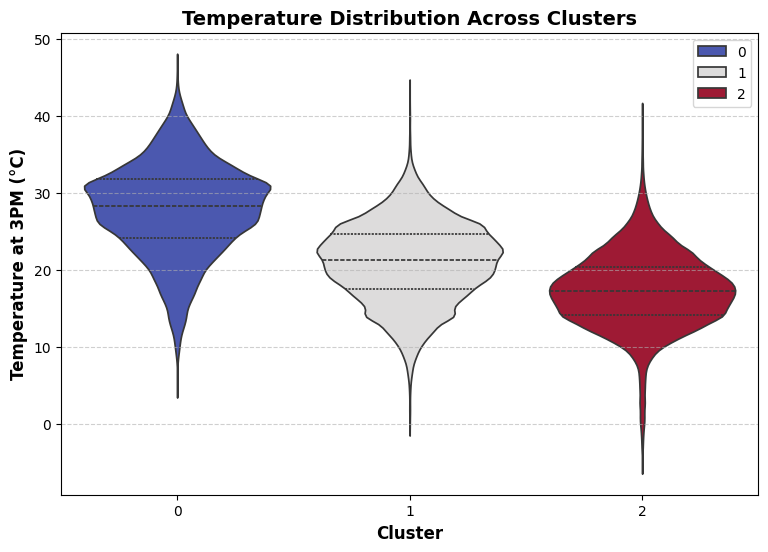

In [443]:
plt.figure(figsize=(9, 6))
sns.violinplot(x=labels, y=df_cluster["Temp3pm"], palette="coolwarm", inner="quartile", hue=labels)
plt.xlabel("Cluster", fontsize=12, fontweight="bold")
plt.ylabel("Temperature at 3PM (°C)", fontsize=12, fontweight="bold")
plt.title("Temperature Distribution Across Clusters", fontsize=14, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


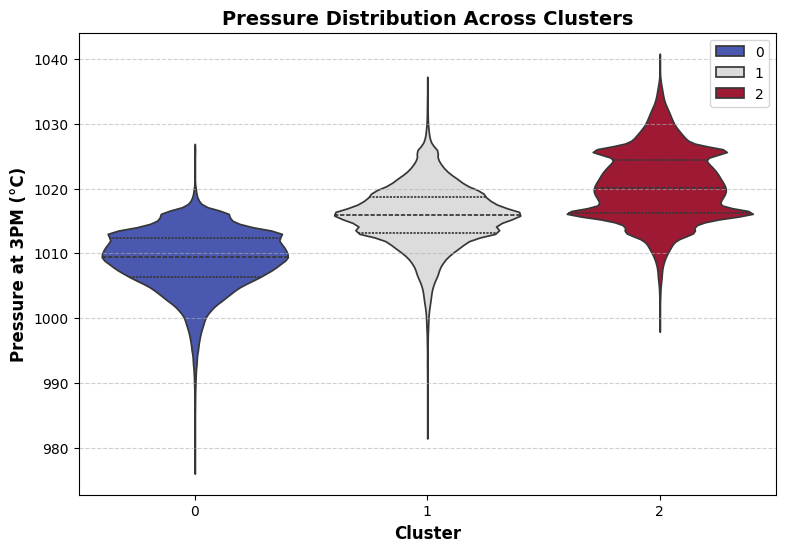

In [444]:
plt.figure(figsize=(9, 6))
sns.violinplot(x=labels, y=df_cluster["Pressure3pm"], palette="coolwarm", inner="quartile", hue=labels)
plt.xlabel("Cluster", fontsize=12, fontweight="bold")
plt.ylabel("Pressure at 3PM (°C)", fontsize=12, fontweight="bold")
plt.title("Pressure Distribution Across Clusters", fontsize=14, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


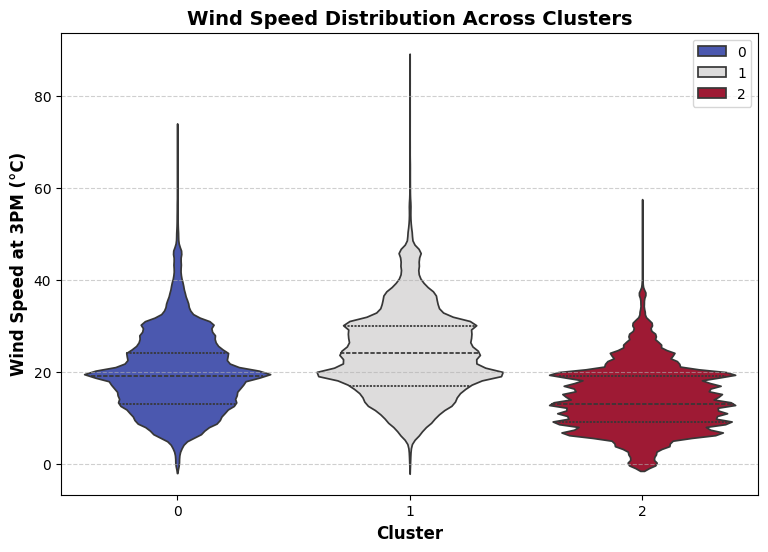

In [445]:
plt.figure(figsize=(9, 6))
sns.violinplot(x=labels, y=df_cluster["WindSpeed3pm"], palette="coolwarm", inner="quartile", hue=labels)
plt.xlabel("Cluster", fontsize=12, fontweight="bold")
plt.ylabel("Wind Speed at 3PM (°C)", fontsize=12, fontweight="bold")
plt.title("Wind Speed Distribution Across Clusters", fontsize=14, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


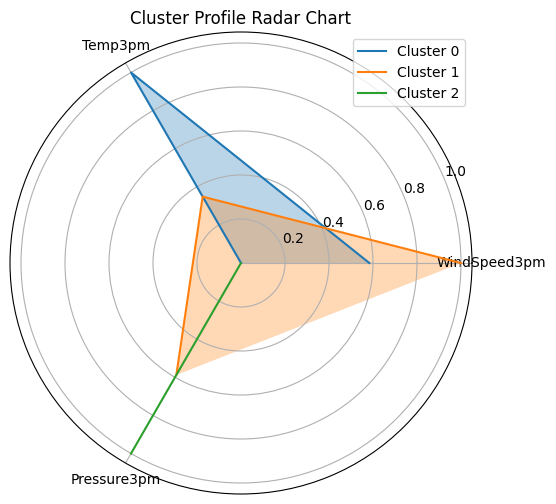

In [446]:
features = ["WindSpeed3pm", "Temp3pm", "Pressure3pm"]
cluster_means = df_cluster.groupby(labels)[features].mean()

# Normalize data
cluster_means = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for cluster, row in cluster_means.iterrows():
    ax.plot(angles, row, label=f"Cluster {cluster}")
    ax.fill(angles, row, alpha=0.3)

ax.set_xticks(angles)
ax.set_xticklabels(features)
plt.legend()
plt.title("Cluster Profile Radar Chart")
plt.show()


# Observations from the Radar Chart

 * Cluster 0 (Blue): High temperature at 3 PM, moderate wind speed, and low pressure.
 * Cluster 1 (Orange): High wind speed, moderate pressure, and low temperature.
 * Cluster 2 (Green): Very high pressure, low wind speed, and low temperature.

In [447]:
df.to_csv('ClusteredData.csv', index=False)